# Imports

In [1]:
import numpy as np
from sklearn import preprocessing

from dataset.dataset import Dataset
from models.neural_net import NeuralNet
from models.sampled_net import SampledNet
from utils.preprocessing import find_center_and_magnitude
from utils.utilities import loss_mse
from view.visualizer import plot_2D_heat_map_of_a_list_of_pairs, initial_network_vs_converted_sampled_network, \
    plot_vector_differences



# Dataset creation

In [2]:
num_samples_adam_training = 500
num_samples_dataset_sampling = 500
num_samples_dataset_testing = 200
epochs = 150
l = [100]

# create a dataset for training Adam
dataset_adam_training = Dataset()
dataset_adam_training.create_dataset_laplacian_of_gaussian(num_samples_adam_training)
dataset_adam_training.scale(preprocessing.MinMaxScaler(feature_range=(-2, 2)))
dataset_adam_training.split_train_test(0.2)

# Dataset to be used in the conversion algorithm
dataset_sampling = Dataset()
dataset_sampling.create_dataset_laplacian_of_gaussian(num_samples_dataset_sampling)
dataset_sampling.scale(preprocessing.MinMaxScaler(feature_range=(-2, 2)))
dataset_sampling.split_train_test(0.2)

#Dataset to be used in testing
dataset_testing = Dataset()
dataset_testing.create_dataset_laplacian_of_gaussian(num_samples_dataset_testing)
dataset_testing.scale(preprocessing.MinMaxScaler(feature_range=(-2, 2)))
dataset_testing.split_train_test(0.2)



# Neural Network training with Adam

In [3]:

model_base_adam = NeuralNet()
model_base_adam.fit(dataset_adam_training.X_train, dataset_adam_training.y_train, l, validation_split=0.2,
                    epochs=epochs)
model_base_adam.model.evaluate(dataset_adam_training.X_test, dataset_adam_training.y_test)
model_base_adam.model.evaluate(dataset_adam_training.X_train, dataset_adam_training.y_train)

mean, magnitude = find_center_and_magnitude(model_base_adam.weights[0], model_base_adam.biases[0])
print("Mean of the solution X.w[0]-b[0] = 0", mean)
print("Mean of the magnitude of w[0]", magnitude)

y_base_test = model_base_adam.predict(dataset_testing.X)

Epoch 1/150
10/10 [==============================] - 1s 27ms/step - loss: 1.2933 - val_loss: 0.7211
Epoch 2/150
10/10 [==============================] - 0s 3ms/step - loss: 0.6337 - val_loss: 0.5315
Epoch 3/150
10/10 [==============================] - 0s 3ms/step - loss: 0.5501 - val_loss: 0.5300
Epoch 4/150
10/10 [==============================] - 0s 5ms/step - loss: 0.5424 - val_loss: 0.5099
Epoch 5/150
10/10 [==============================] - 0s 5ms/step - loss: 0.5218 - val_loss: 0.4957
Epoch 6/150
10/10 [==============================] - 0s 3ms/step - loss: 0.5128 - val_loss: 0.4940
Epoch 7/150
10/10 [==============================] - 0s 3ms/step - loss: 0.5105 - val_loss: 0.4920
Epoch 8/150
10/10 [==============================] - 0s 3ms/step - loss: 0.5062 - val_loss: 0.4889
Epoch 9/150
10/10 [==============================] - 0s 3ms/step - loss: 0.5027 - val_loss: 0.4870
Epoch 10/150
10/10 [==============================] - 0s 3ms/step - loss: 0.4999 - val_loss: 0.4853
Epoch 11

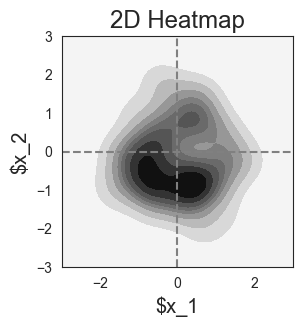

In [4]:

plot_2D_heat_map_of_a_list_of_pairs(model_base_adam.weights[0].T[:, 0], model_base_adam.weights[0].T[:, 1])


# Network Conversion to Sampled Network.
### Lowest Angle Approach


Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 6395.41it/s]


loss(y_base, y_sampled)
r2: -12.514518418073207	mse: 1.5941419684698184
are given weight matrices equal:  False
Correlation of weight vector norms: 0.0826


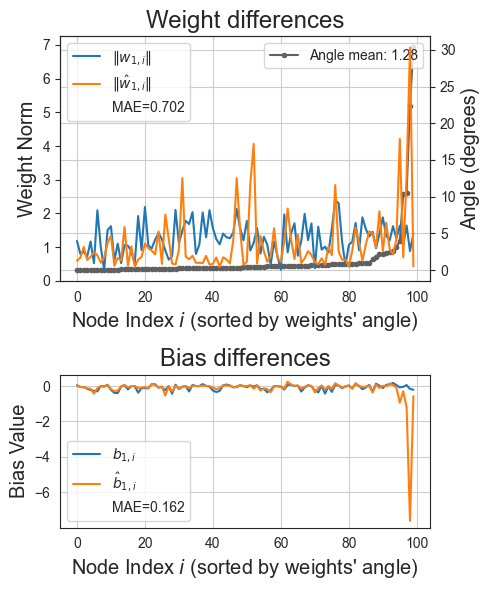

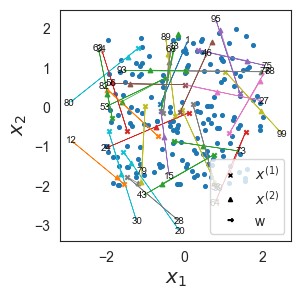

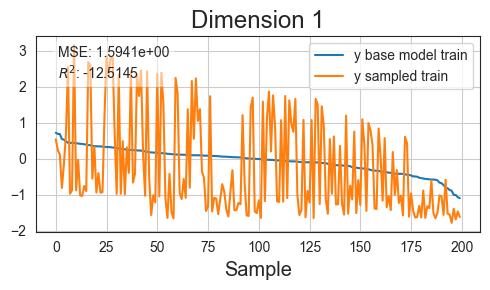

In [5]:
model_sampled = SampledNet()
x_1_x2_tuples = model_sampled.fit(dataset_sampling.X, model_base_adam, layer2="bias_only", choose_x_2="angle")

initial_network_vs_converted_sampled_network(dataset_testing, model_base_adam, model_sampled, x_1_x2_tuples)

### Threshold Ratio and Weight Norm Preservation

Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 510.24it/s]


loss(y_base, y_sampled)
r2: 0.9009050870511256	mse: 0.011689011380709362
are given weight matrices equal:  False
Correlation of weight vector norms: 0.9963


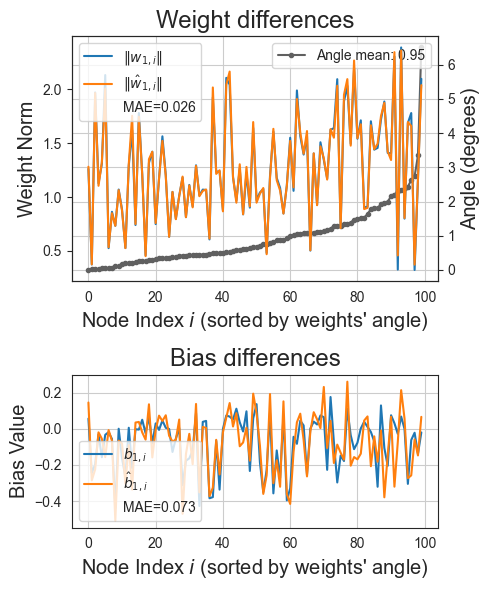

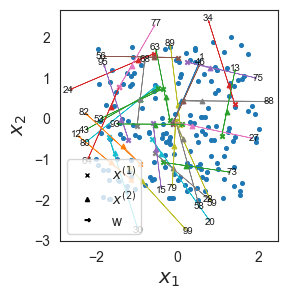

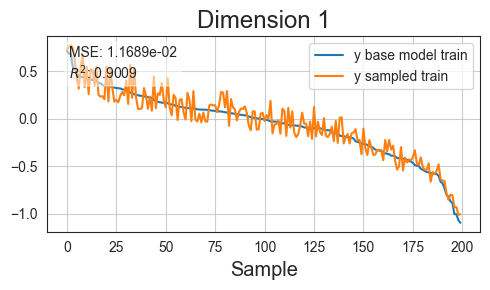

In [6]:
model_sampled = SampledNet()
x_1_x2_tuples = model_sampled.fit(dataset_sampling.X, model_base_adam, layer2="bias_only", r=0.04,
                                  choose_x_2="norm")
initial_network_vs_converted_sampled_network(dataset_testing, model_base_adam, model_sampled, x_1_x2_tuples)


### Pair Selection with Proximity Optimization


Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 514.07it/s]


False
loss(y_base, y_sampled)
r2: 0.8948810524170131	mse: 0.012399592855585442
are given weight matrices equal:  False
Correlation of weight vector norms: 0.9956


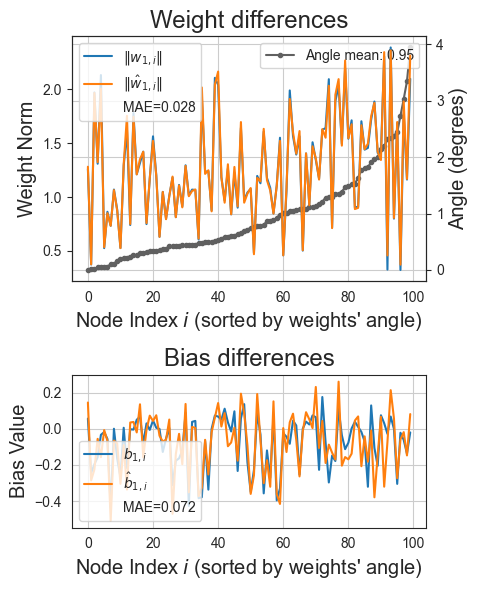

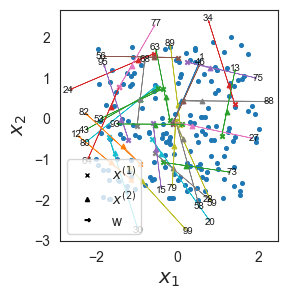

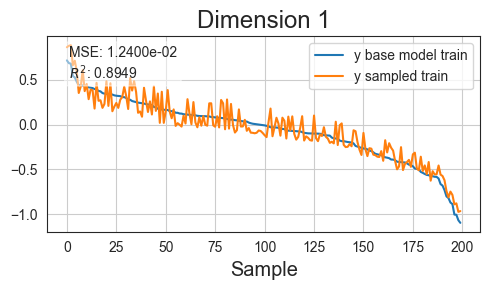

In [7]:
model_sampled = SampledNet()
xx_1_x2_tuples = model_sampled.fit(dataset_sampling.X, model_base_adam, layer2="bias_only", r=0.04,
                                   choose_x_2="norm_kdtree")
print(np.array_equal(xx_1_x2_tuples, x_1_x2_tuples))
initial_network_vs_converted_sampled_network(dataset_testing, model_base_adam, model_sampled, x_1_x2_tuples)


### Optimizing the Bias: Shift x_1 and x_2 so that x_1 lies on the activation boundary hyperplane

Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 409.24it/s]


loss(y_base, y_sampled)
r2: 0.9571998889761892	mse: 0.0050486041105970905
are given weight matrices equal:  False
Correlation of weight vector norms: 0.9963


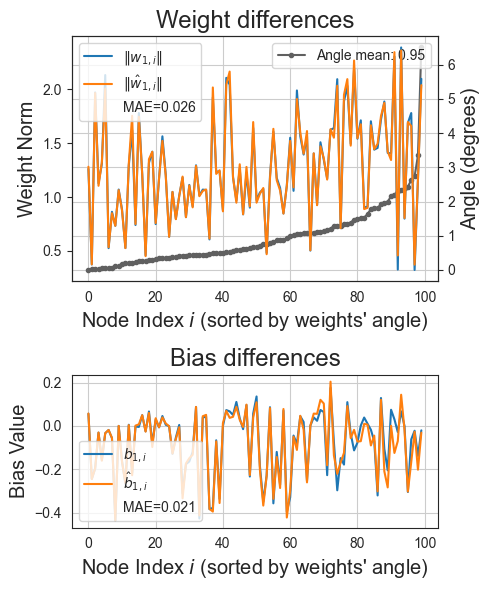

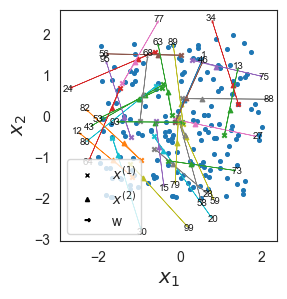

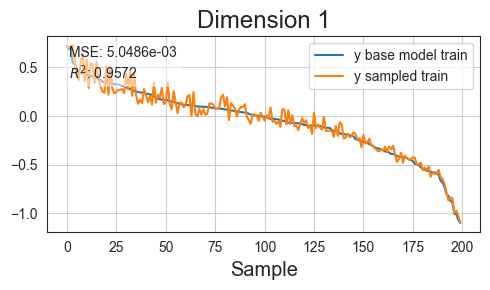

In [8]:
model_sampled = SampledNet()
x_1_x2_tuples = model_sampled.fit(dataset_sampling.X, model_base_adam, layer2="bias_only", r=0.04,
                                  choose_x_2="norm", project_onto_boundary=True)

initial_network_vs_converted_sampled_network(dataset_testing, model_base_adam, model_sampled, x_1_x2_tuples)


### Ridge Regression for Layer 2
#### 1. Hyper parameter search for the best alpha

Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 480.85it/s]


alpha 	loss validation
0.0001 	9.713e-05
0.001 	9.849e-05
0.01 	1.417e-04
0.1 	2.656e-04
1 	1.064e-03
10 	6.319e-03
100 	2.006e-02
loss(y_base, y_sampled)
r2: 0.9991374818626306	mse: 0.00010174068500348705
are given weight matrices equal:  False
Correlation of weight vector norms: 0.9963


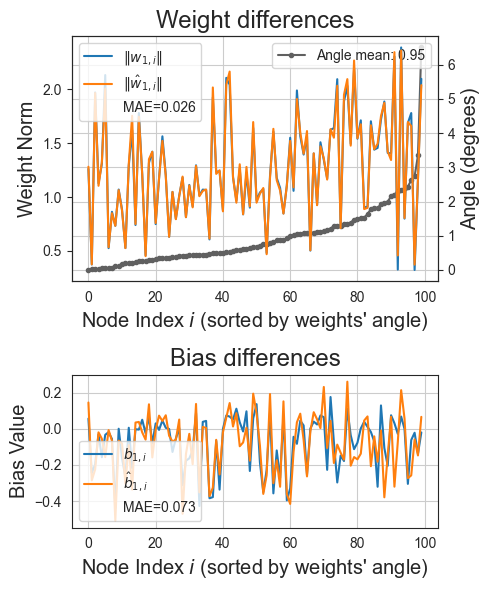

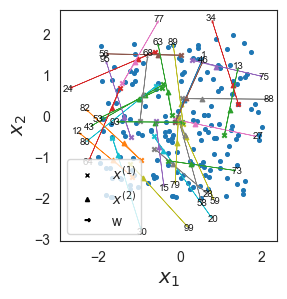

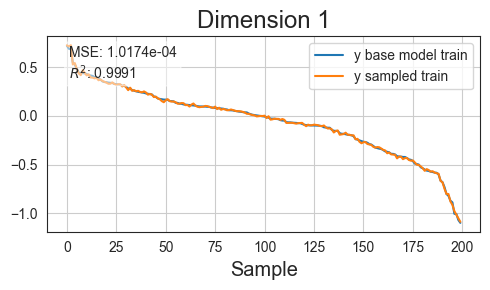

In [9]:
model_sampled = SampledNet()
model_sampled.fit(dataset_sampling.X, model_base_adam, layer2="ridge", r=0.04,
                  choose_x_2="norm")

initial_network_vs_converted_sampled_network(dataset_testing, model_base_adam, model_sampled, x_1_x2_tuples)


#### 2. Hyperparameter search for the best r and alpha


ratio: 0.000


Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 6393.17it/s]


alpha 	loss validation
0.0001 	9.127e-05
0.001 	8.365e-05
0.01 	1.503e-04
0.1 	6.244e-04
1 	2.959e-03
10 	1.207e-02
100 	3.144e-02

ratio: 0.056


Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 304.76it/s]


alpha 	loss validation
0.0001 	1.814e-04
0.001 	1.876e-04
0.01 	1.609e-04
0.1 	2.208e-04
1 	1.226e-03
10 	7.252e-03
100 	2.094e-02

ratio: 0.111


Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 172.00it/s]


alpha 	loss validation
0.0001 	1.680e-04
0.001 	1.634e-04
0.01 	2.108e-04
0.1 	3.284e-04
1 	7.690e-04
10 	3.716e-03
100 	1.341e-02

ratio: 0.167


Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 112.42it/s]


alpha 	loss validation
0.0001 	2.146e-04
0.001 	2.061e-04
0.01 	2.202e-04
0.1 	4.013e-04
1 	1.254e-03
10 	4.654e-03
100 	1.872e-02

ratio: 0.222


Layer1 sampling: 100%|██████████| 100/100 [00:01<00:00, 90.89it/s]


alpha 	loss validation
0.0001 	4.195e-04
0.001 	3.904e-04
0.01 	3.237e-04
0.1 	4.289e-04
1 	9.033e-04
10 	3.880e-03
100 	1.876e-02

ratio: 0.278


Layer1 sampling: 100%|██████████| 100/100 [00:01<00:00, 73.12it/s]


alpha 	loss validation
0.0001 	5.786e-04
0.001 	5.719e-04
0.01 	6.187e-04
0.1 	9.818e-04
1 	2.153e-03
10 	7.911e-03
100 	2.534e-02

ratio: 0.333


Layer1 sampling: 100%|██████████| 100/100 [00:01<00:00, 64.48it/s]


alpha 	loss validation
0.0001 	7.494e-04
0.001 	6.227e-04
0.01 	5.334e-04
0.1 	7.305e-04
1 	1.852e-03
10 	9.063e-03
100 	3.221e-02

ratio: 0.389


Layer1 sampling: 100%|██████████| 100/100 [00:01<00:00, 55.59it/s]


alpha 	loss validation
0.0001 	1.537e-03
0.001 	1.415e-03
0.01 	1.250e-03
0.1 	1.214e-03
1 	1.705e-03
10 	7.660e-03
100 	2.770e-02

ratio: 0.444


Layer1 sampling: 100%|██████████| 100/100 [00:02<00:00, 45.38it/s]


alpha 	loss validation
0.0001 	1.050e-03
0.001 	9.949e-04
0.01 	9.493e-04
0.1 	1.362e-03
1 	2.890e-03
10 	1.039e-02
100 	3.266e-02

ratio: 0.500


Layer1 sampling: 100%|██████████| 100/100 [00:02<00:00, 42.20it/s]


alpha 	loss validation
0.0001 	7.254e-04
0.001 	6.428e-04
0.01 	6.648e-04
0.1 	9.961e-04
1 	2.011e-03
10 	7.285e-03
100 	2.290e-02
Best values for the hyperparameters:
alpha: 0.001
r: 0.0
loss(y_base, y_sampled)
r2: 0.9990940050684256	mse: 0.00010686910912875776
are given weight matrices equal:  False
Correlation of weight vector norms: 0.9380


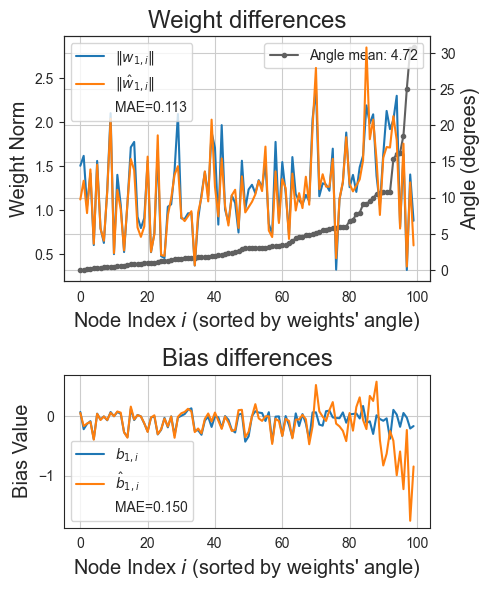

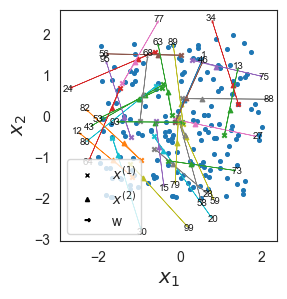

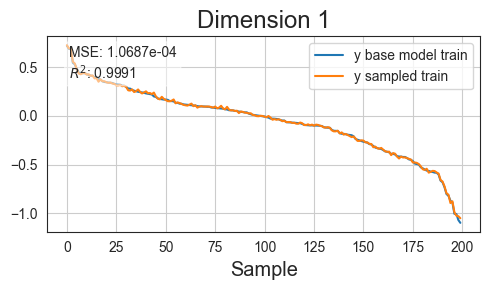

In [10]:
model_sampled = SampledNet()
alpha, r = model_sampled.fit(dataset_sampling.X, model_base_adam, layer2="ridge", r=-1, alpha=-1,
                             choose_x_2="norm")
print("Best values for the hyperparameters:")
print(f"alpha: {alpha}")
print(f"r: {r}")

initial_network_vs_converted_sampled_network(dataset_testing, model_base_adam, model_sampled, x_1_x2_tuples)


### Calculate r vs loss, using Weight Norm PReservation Approach for the first layer, and Bias only Update for the second layer

In [11]:

weight1 = []
weight2 = []
losses = []
biases = []
radii = np.linspace(0, 0.4, 10)
for r in radii:
    print(f"r {r}")

    model_sampled = SampledNet()
    model_sampled.fit(
        dataset_sampling.X, model_base_adam, layer2="bias_only", r=r, verbose=0
    )
    weight1.append(model_sampled.weights[0])
    weight2.append(model_base_adam.weights[0])
    biases.append(model_sampled.biases[0])

    y_sampled_test = model_sampled.predict(dataset_testing.X)
    loss_sampled_to_base = loss_mse(y_sampled_test, y_base_test)
    losses.append(loss_sampled_to_base)
    print(f"loss{loss_sampled_to_base}\n")


r 0.0


Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 6381.89it/s]


loss0.11943416450393368

r 0.044444444444444446


Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 400.05it/s]


loss0.010733007162840702

r 0.08888888888888889


Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 201.52it/s]


loss0.02325624646075633

r 0.13333333333333333


Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 142.55it/s]


loss0.03132667975792903

r 0.17777777777777778


Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 105.69it/s]


loss0.014927930009749972

r 0.22222222222222224


Layer1 sampling: 100%|██████████| 100/100 [00:01<00:00, 87.21it/s]


loss0.045275042774774954

r 0.26666666666666666


Layer1 sampling: 100%|██████████| 100/100 [00:01<00:00, 75.61it/s]


loss0.032294863600720446

r 0.3111111111111111


Layer1 sampling: 100%|██████████| 100/100 [00:01<00:00, 57.08it/s]


loss0.31248776354678776

r 0.35555555555555557


Layer1 sampling: 100%|██████████| 100/100 [00:01<00:00, 53.59it/s]


loss0.36762287503515495

r 0.4


Layer1 sampling: 100%|██████████| 100/100 [00:02<00:00, 48.23it/s]

loss0.6840662945487103



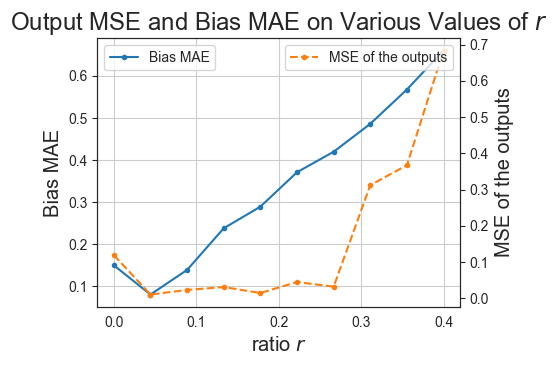

In [12]:
plot_vector_differences(weight1, weight2, model_base_adam.biases[0], biases, radii, losses)

### Data Augmentation with Gaussian Sampling

Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 102.99it/s]


Before data augmentation
loss(y_base, y_sampled)
r2: 0.33231612500664	mse: 0.07741819937147582
are given weight matrices equal:  False
Correlation of weight vector norms: 0.9387


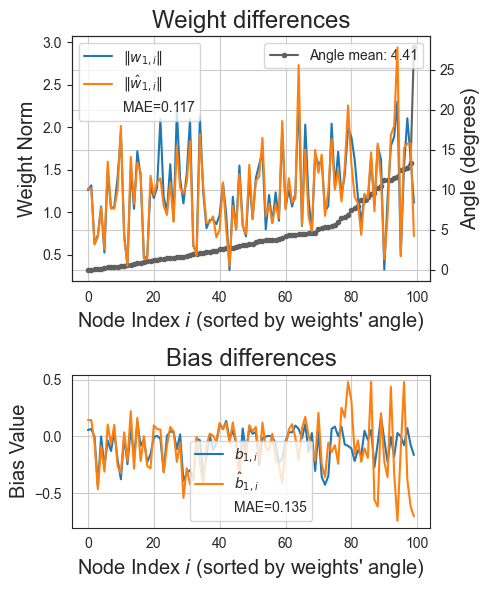

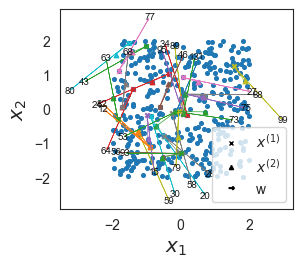

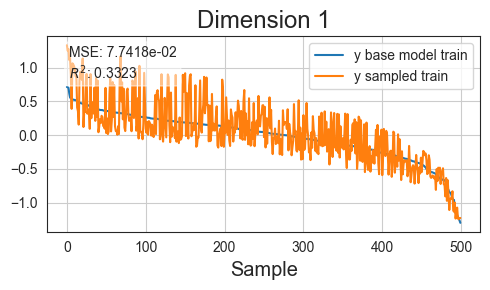

After data augmentation
loss(y_base, y_sampled)
r2: 0.8839603066588435	mse: 0.013454846598144827
are given weight matrices equal:  False
Correlation of weight vector norms: 0.9996


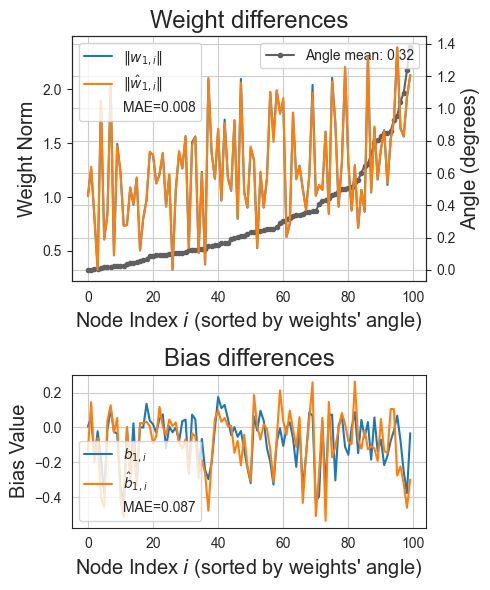

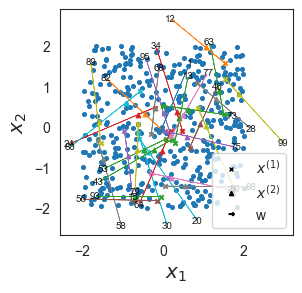

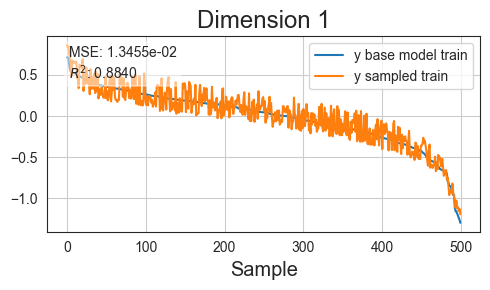

In [13]:
xd = 3  # Input space dimensions
yd = 4  # Output dimension
num_samples = 100  # Number of data points
epochs = 300  # Number of training epochs
l = [100]  # Number of neurons in each layer

dataset_sampling_lower_number_of_samples = dataset_sampling.get_subset(num_samples)

model_sampled = SampledNet()
x_1_x2_tuples = model_sampled.fit(dataset_sampling_lower_number_of_samples.X, model_base_adam,
                                  layer2="bias_only", r=0.04,
                                  choose_x_2="norm")

model_sampled_input_augmented = SampledNet()
x_1_X2_tuples_input_augmented = model_sampled_input_augmented.fit(dataset_sampling_lower_number_of_samples.X
                                                                  , model_base_adam,
                                                                  layer2="bias_only",
                                                                  r=0.04,
                                                                  choose_x_2="norm", augment_data=(0.5, 10))

print("Before data augmentation")
initial_network_vs_converted_sampled_network(dataset_sampling, model_base_adam, model_sampled, x_1_x2_tuples)
print("After data augmentation")
initial_network_vs_converted_sampled_network(dataset_sampling, model_base_adam, model_sampled_input_augmented,
                                             x_1_X2_tuples_input_augmented)
